In [1]:
import pandas as pd
import numpy as np
import os

import logging
logging.getLogger().setLevel(logging.INFO)

from alphabase.spectral_library.flat import SpecLibFlat
from alphabase.spectral_library.base import SpecLibBase
from alphabase.spectral_library.reader import LibraryReaderBase
from alphadia.extraction.utils import reannotate_fragments
from alphabase.psm_reader import psm_reader_provider

INFO:root:


In [5]:
import warnings 

def fragment_number(precursor_df, fragment_intensity_df) :
    if not set(['frag_start_idx', 'frag_stop_idx']).issubset(precursor_df.columns):
        warnings.warn('frag_start_idx and frag_stop_idx not in dataframe')
        return
    
    n_fragments = []
    
    for start, stop in zip(precursor_df['frag_start_idx'].values, precursor_df['frag_stop_idx'].values):
        n_fragments += [np.sum(fragment_intensity_df.iloc[start:stop].values > 0)]

    precursor_df['n_fragments'] = n_fragments

In [6]:
lib_location = '/Users/georgwallmann/Documents/data/alphadia_benchmarking/libraries/patricia_hela/21min_Evosep_HeLa_BR14_48fractions_diaPASEF_py_diAID_2.tsv'
#insilico_lib_location = '/Users/georgwallmann/Documents/data/libraries/2022_111_brunner_2022_1ng_all_29_human_trypsin_diann_decoy.hdf'


In [7]:
# create dense library from diann psm file
target_lib = LibraryReaderBase()
target_lib.import_file(lib_location)

#target_lib._fragment_mz_df = target_lib._fragment_mz_df[['b_z1', 'b_z2', 'y_z1', 'y_z2']]
#target_lib._fragment_intensity_df = target_lib._fragment_intensity_df[['b_z1', 'b_z2', 'y_z1', 'y_z2']]

/Users/georgwallmann/Documents/git/alphabase/alphabase/spectral_library/reader.py:250: DtypeWarning: Columns (33,34) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filename, sep=self.csv_sep)


,uniprot_ids,mods,precursor_mz,proteins,charge,mod_sites,raw_name,nAA,genes,mobility,rt,sequence,frag_start_idx,frag_stop_idx,rt_norm,ccs
0,A0A024RBG1,,487.600052,NUD4B_HUMAN,3,,20220715_TIMS03_PaSk_SA_HeLa_Evo05_21min_IM07-...,12,NUDT4B,0.777,37.883335,LLGIFEQNQDRK,0,11,0.255296,471.228582
1,A0A024RBG1,,666.848958,NUD4B_HUMAN,2,,20220715_TIMS03_PaSk_SA_HeLa_Evo05_21min_IM07-...,11,NUDT4B,0.969,55.980396,LLGIFEQNQDR,11,21,0.371505,392.136762
2,A0A024RBG1,,730.896440,NUD4B_HUMAN,2,,20220715_TIMS03_PaSk_SA_HeLa_Evo05_21min_IM07-...,12,NUDT4B,1.041,37.883335,LLGIFEQNQDRK,21,32,0.251158,420.894147
3,A0A087WSZ0,,691.347175,KVD08_HUMAN,3,,20220715_TIMS03_PaSk_SA_HeLa_Evo05_21min_IM07-...,18,IGKV1D-8,0.921,49.475310,MSQGISSYLAWYQQKPGK,32,49,0.328335,557.012501
4,A0A096LP01,,539.756204,SIM26_HUMAN,2,,20220715_TIMS03_PaSk_SA_HeLa_Evo05_21min_IM07-...,9,SMIM26,0.864,1.100495,EDFVPNTEK,49,57,0.007416,350.490584
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235305,Q9Y6Y8,Oxidation@M;Carbamidomethyl@C,899.917206,S23IP_HUMAN,2,8;9,20220715_TIMS03_PaSk_SA_HeLa_Evo05_21min_IM07-...,15,SEC23IP,1.131,133.626900,IDMESLLMCTVDDLK,3084898,3084912,0.885915,456.474882
235306,Q9Y6Y8,Oxidation@M;Carbamidomethyl@C,899.917206,S23IP_HUMAN,2,3;9,20220715_TIMS03_PaSk_SA_HeLa_Evo05_21min_IM07-...,15,SEC23IP,1.144,94.400870,IDMESLLMCTVDDLK,3084912,3084926,0.625856,461.721720
235307,Q9Y6Y8,Oxidation@M;Oxidation@M,447.473638,S23IP_HUMAN,4,3;13,20220715_TIMS03_PaSk_SA_HeLa_Evo05_21min_IM07-...,15,SEC23IP,0.821,34.524582,VGMEINHLHALFMSR,3084926,3084940,0.232662,662.744153
235308,Q9Y6Y8,Oxidation@M;Oxidation@M,596.295758,S23IP_HUMAN,3,3;13,20220715_TIMS03_PaSk_SA_HeLa_Evo05_21min_IM07-...,15,SEC23IP,0.884,34.524582,VGMEINHLHALFMSR,3084940,3084954,0.228079,535.202532


In [8]:
target_lib._precursor_df['elution_group_idx'] = np.arange(len(target_lib._precursor_df))

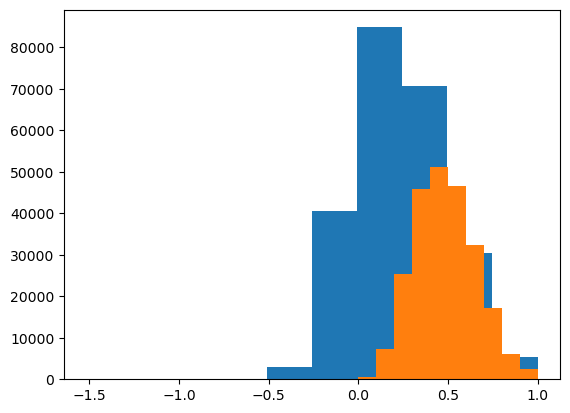

In [9]:
import matplotlib.pyplot as plt
_ = plt.hist(target_lib._precursor_df['rt_norm'])
target_lib.precursor_df = target_lib.precursor_df[target_lib.precursor_df['rt_norm'] > -0.5].copy()

# scale rt_norm to from min max to 0-1
target_lib.precursor_df['rt_norm'] = (target_lib.precursor_df['rt_norm'] - target_lib.precursor_df['rt_norm'].min())/(target_lib.precursor_df['rt_norm'].max() - target_lib.precursor_df['rt_norm'].min())
_ = plt.hist(target_lib._precursor_df['rt_norm'])

In [16]:
target_lib._precursor_df.elution_group_idx.value_counts()

139790    2
151009    2
122729    2
133153    2
109531    2
         ..
66267     1
78368     1
78383     1
204041    1
28846     1
Name: elution_group_idx, Length: 231149, dtype: int64

In [11]:
#target_lib._precursor_df['elution_group_idx'] = np.arange(len(target_lib._precursor_df))
fragment_number(target_lib.precursor_df, target_lib._fragment_intensity_df)

In [12]:
target_lib.decoy = 'diann'
target_lib.append_decoy_sequence()
target_lib.calc_precursor_mz()

In [13]:
from peptdeep.pretrained_models import ModelManager
from alphabase.peptide.fragment import get_charged_frag_types

frag_types = get_charged_frag_types(
    ['b','y','b_modloss', 'y_modloss'], 
    2
)

model_mgr = ModelManager()

model_mgr.nce = 30
model_mgr.instrument = 'timsTOF'

In [14]:
res = model_mgr.predict_all(
    target_lib.precursor_df,
    predict_items=['ms2'],
    frag_types = frag_types,
)

target_lib._precursor_df = res['precursor_df']
target_lib._fragment_mz_df = res['fragment_mz_df']
target_lib._fragment_intensity_df = res['fragment_intensity_df']

2023-03-08 12:36:30> Using multiprocessing with 8 processes ...
2023-03-08 12:36:30> Predicting ms2 ...


100%|██████████| 46/46 [01:34<00:00,  2.06s/it]


In [ ]:
for i, (start_idx, stop_idx, k_allowed) in enumerate(zip(output_lib.precursor_df['frag_start_idx'].values, output_lib.precursor_df['frag_stop_idx'].values,output_lib.precursor_df['n_fragments'].values)):
    intensies = output_lib._fragment_intensity_df.iloc[start_idx:stop_idx].values
    flat_intensities = np.sort(intensies.flatten())[::-1]
    output_lib._fragment_intensity_df.iloc[start_idx:stop_idx].values[intensies <= flat_intensities[k_allowed]] = 0


In [18]:
fragment_number(target_lib.precursor_df, target_lib._fragment_intensity_df)

<AxesSubplot:xlabel='n_fragments', ylabel='Count'>

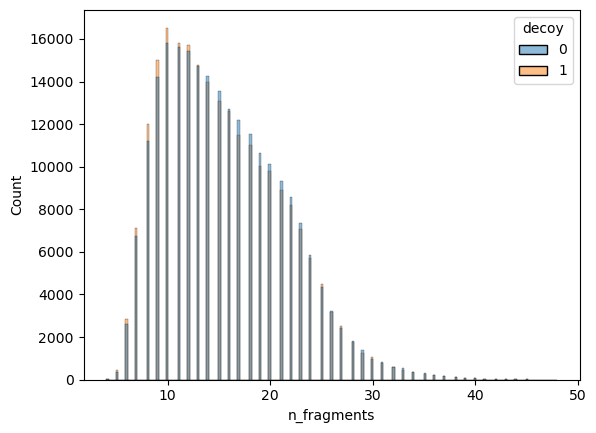

In [19]:
import seaborn as sns
sns.histplot(target_lib.precursor_df, x ='n_fragments', hue='decoy')

In [20]:
from tqdm import tqdm
from alphabase.peptide.precursor import get_mod_seq_formula
from alphabase.constants.isotope import IsotopeDistribution


def calc_isotope_dist(precursor_df, max_isotope = 6, min_intensity = 0.001):
    isotope_dist = IsotopeDistribution()

    col_names = ['i_{}'.format(i) for i in range(max_isotope)]
    precursor_df[col_names] = 0.

    for i in tqdm(range(len(precursor_df))):

        row = precursor_df.iloc[i]
        dist, mono = isotope_dist.calc_formula_distribution(
            get_mod_seq_formula(row['sequence'], row['mods'])
        )
        dist[dist < 0.001] = 0.
        dist = dist / dist.sum()
        precursor_df.loc[i, col_names] = dist[:max_isotope]

In [21]:
calc_isotope_dist(target_lib.precursor_df)

100%|██████████| 460153/460153 [02:59<00:00, 2564.00it/s]


In [23]:
target_lib._precursor_df.drop(columns=['rt'], inplace=True)

In [24]:
output_location = '/Users/georgwallmann/Documents/data/alphadia_benchmarking/libraries/patricia_hela/21min_Evosep_HeLa_BR14_48fractions_diaPASEF_py_diAID_2_egs.hdf'
target_lib.save_hdf(output_location)

In [22]:
res = model_mgr.predict_all(
    output_lib.precursor_df,
    predict_items=['ms2'],
    frag_types = frag_types,
)

output_lib._precursor_df = res['precursor_df']
output_lib._fragment_mz_df = res['fragment_mz_df']
output_lib._fragment_intensity_df = res['fragment_intensity_df']

2023-03-06 20:14:31> Using multiprocessing with 8 processes ...
2023-03-06 20:14:31> Predicting ms2 ...


100%|██████████| 46/46 [01:34<00:00,  2.06s/it]


In [23]:
fragment_number(output_lib.precursor_df, output_lib._fragment_intensity_df)

<AxesSubplot:xlabel='n_fragments', ylabel='Count'>

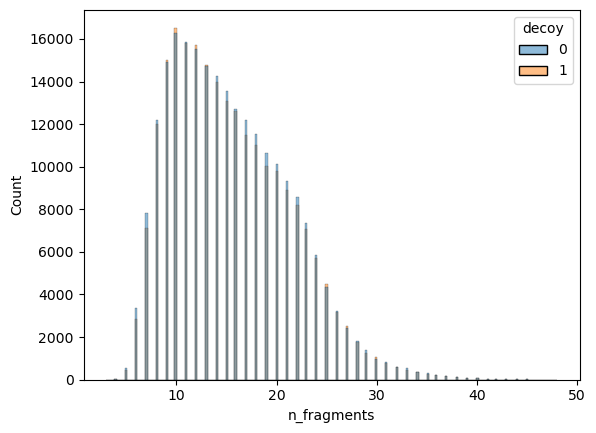

In [24]:
import seaborn as sns
sns.histplot(output_lib.precursor_df, x ='n_fragments', hue='decoy')

In [25]:
output_location = '/Users/georgwallmann/Documents/data/alphadia_benchmarking/libraries/patricia_hela/21min_Evosep_HeLa_BR14_48fractions_diaPASEF_py_diAID_2_predicted.hdf'
output_lib.save_hdf(output_location)